In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt

In [2]:
## !! CHANGE ME !! ##
os.chdir('C:\\ali\\packages\\s2p-lbm')

In [75]:
from suite2p.io import lbm as lbmio
from suite2p.suite3d.job import Job

from suite2p.suite3d import iter_step

In [7]:
from utils import tiff_utils as tfu

In [100]:
from dask import array as darr

## Convenience functions

### Loading raw tiffs

In [10]:
## !! CHANGE ME !! ## 
example_tif_dir = 'E:\\Subjects\\AH007\\2022-03-31\\1'

In [15]:
tif_paths = tfu.get_tif_paths(example_tif_dir)
example_tif_path = tifs[0]

In [16]:
print(example_tif_path)

E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00001.tif


In [17]:
# loads lbm tif files directly into memory 
# If you provide a list of paths, it will load all files and concatenate them along the time axis
# Loads all strips and stitch them back together into one large image, and de-interleaves the planes
# You can specify how many planes you want to load at once. 
# Plane 0 is deepest, 1 is second deepest, 30 is shallowest (not the wacky ScanImage channel order)
# Optionally applies a spatiotemporal filter to remove 200 Hz line noise (see usage later in this notebook)
mov = lbmio.load_and_stitch_tifs([example_tif_path], planes = n.arange(15),
                                 verbose=True, n_proc = 15, filt=None)

Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00001.tif
Loaded 1 files, total 3.41 GB


In [31]:
print(mov.shape)

# num planes, timepoints, ypix, xpix
nz, nt, ny, nx = mov.shape

(15, 100, 1202, 1015)


### Get tiff metadata

In [40]:
volume_rate = tfu.get_vol_rate(example_tif_path)
print(volume_rate)

2.7984


In [38]:
scanner_frequency = tfu.get_tif_tag(example_tif_path, 'SI.hScan2D.scannerFrequency', number=True)
print(scanner_frequency)

12027.5


### Displaying tiffs

In [20]:
im3d = mov.mean(axis=1)

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x256f0f4cf10>)

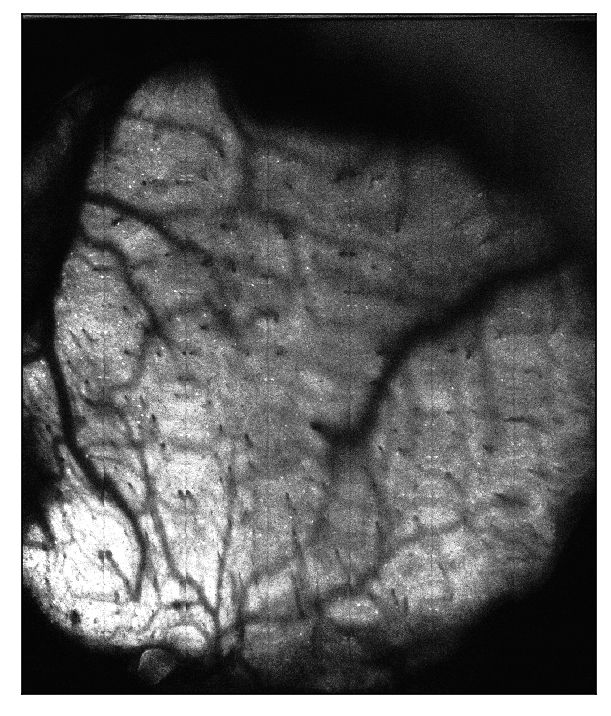

In [69]:
# Display plane 10
tfu.show_tif(im3d[9])

## Initial pass

In [44]:
job_params = {
    'exp_str' : "test_experiment_001", #unique ID for the experiment
    'planes' : n.arange(5,10), # planes to analyze
    'fs' : volume_rate,
    'notch_filt' : {"f0" : 200, 'Q' : 1, 'line_freq' : scanner_frequency}, # notch filter to remove line noise. 
                                                                          # set to none if you don't need it
    
    'subtract_crosstalk' : True, # subtract crosstalk from lower 15 planes to upper 15 planes
    'override_crosstalk' : 0.21, # set to None to try to compute it from data
                                # I usually compute it once and use the same value
    
    'nonrigid' : True, # do nonrigid registration
    'smooth_sigma' : 1.15, 'maxregshift' : 0.15, 'reg_filter_pcorr': 1, #s2p reg params, works fine for me
    'generate_sample_registered_bins' : False, # create and save some example registered binaries in the initial phase
                                              # for debugging and comparing parameters
    
    'dtype' : n.float32, 
    'n_init_files' : 3, # number of files to use for the initialization pass to compute registration
                        # reference image, as well the plane-to-plane shifts & crosstalk. Should be 2+.
                        # Takes ~ 15 ish minutes per file
    'init_file_pool' : None,  # set to None to sample n_init_files from all tifs for initialization files
    'init_file_sample_method' : 'even', # 'random' for picking the initialization files randomly, 'even' for even spacing
    
    'total_tifs_to_analyze' : None, # None to analyze all tifs, set to an int to stop processing after XX tifs
    'tif_batch_size' : 1, # number of tifs to analyze at once. Doesn't make it significantly faster, so leave at 1.
    'load_from_binary' : False, # if you've already registered them, you can load tifs from binaries
    
}

In [45]:
## !! Change Me !! ##
analysis_dir = 'Y:\\analysis\\example'
os.mkdir(analysis_dir)

In [46]:
tifs = tfu.get_tif_paths(example_tif_dir)

In [50]:
job = Job(analysis_dir, job_params['exp_str'], job_params, tifs, verbosity=10, exist_ok=True, create=True)

Creating job directory for test_experiment_001 in Y:\analysis\example
      Created dir Y:\analysis\example\s3d-test_experiment_001\registered_data
      Created dir Y:\analysis\example\s3d-test_experiment_001\summary
      Created dir Y:\analysis\example\s3d-test_experiment_001\iters
      Updated params file: Y:\analysis\example\s3d-test_experiment_001\params.npy


In [ ]:
job.run_init_pass()

Launching initial pass
Saving summary to Y:\analysis\example\s3d-test_experiment_001\summary\summary.npy
Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00061.tif
Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00121.tif
Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00181.tif
Loaded 3 files, total -1.00 GB
   Subtracting crosstalk with forced coefficient 0.210
   Building ops file
Setting smooth_sigma: 1.15
Setting maxregshift: 0.15
Setting Ly: 1202
Setting Lx: 1015
Setting nonrigid: True
   Aligning planes and calculating reference images
   Computing reference images


In [60]:
# all of the logging during the initialization and the subsequent steps
# is also saved at job.logfile. If you close the notebook window or disconnect,
# you can still go back and see any errors/warning that come up there
print("See %s for logs" % job.logfile)

See Y:\analysis\example\s3d-test_experiment_001\log.txt for logs


In [55]:
# all of the results are saved in the summary object, at job.dirs['summary']
# If you re-run this notebook a second time, you can skip running the job.init_step() line
# and just load the results instead
print("Loading summary from %s" % job.dirs['summary'])
summary = job.load_summary()

Loading summary from Y:\analysis\example\s3d-test_experiment_001\summary


In [53]:
summary.keys()

dict_keys(['ref_img_3d', 'crosstalk_coeff', 'plane_shifts', 'refs_and_masks', 'all_ops', 'plane_mean', 'plane_std'])

Text(0, 0.5, 'Shift (pixels)')

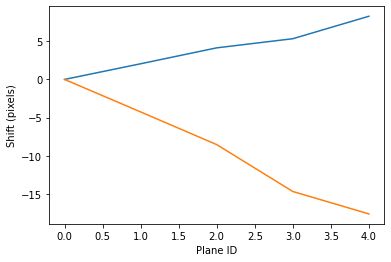

In [63]:
plt.plot(summary['plane_shifts'])
plt.xlabel("Plane ID")
plt.ylabel("Shift (pixels)")

In [71]:
summary.keys()

dict_keys(['ref_img_3d', 'crosstalk_coeff', 'plane_shifts', 'refs_and_masks', 'all_ops', 'plane_mean', 'plane_std'])

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x256f0f329a0>)

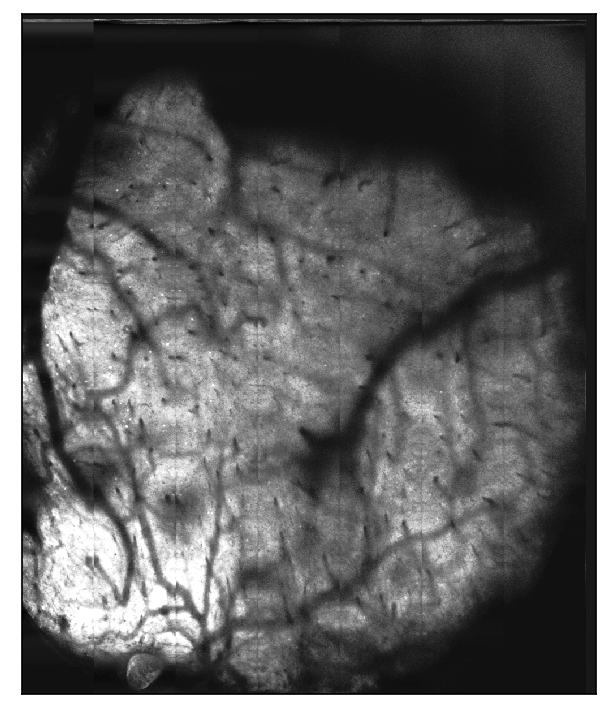

In [68]:
# This is the "Reference Image" that all frames will be registered to.
# Check to see how this compares to the image plotted above (tfu.show_tif(im3d[9]))
# You should notice two things that are different:
# 1. this image is shifted in xy by the plane shifts calculated in the plot above
# 2. this image is less noisy and higher quality, because it is an average of frames that were
# registered to each other

# Notice the index, this is plane 4 in this job because we set the job_params['planes'] parameter 
# to only analyze planes 5,6,7,8,9. So, plane 4 in this job actually corresponds to plane 9 in the 
# original stack. 
tfu.show_tif(summary['ref_img_3d'][4])

## Registration

In [73]:
# These are correlation map-specific parameters
job.params['running_sdmov'] = True # estimate standard deviation with an on-line algorithm 
                                   # to allow for registration and correlation map in one pass instead of two
job.params['intensity_threshold'] = True # weird parameter, don't touch it
job.params['temporal_high_pass_width'] = 100 # temporal high pass filter limit, unit is frames
                                             # you can't set this higher than the number of frames in your batch
job.params['npil_high_pass_xy'] = 35  # high pass filter for neuropil, in pixels
job.params['npil_high_pass_z']  = 1   # same, in z
job.params['detection_unif_filter_xy'] = 3 # detection filter in pixels
job.params['detection_unif_filter_z']  = 3 # same, in z

In [78]:
# for the sake of time, I only iterate through the first 10 tifs

# This is very verbose, you can set job.verbosity = 2 or 1 to make it quieter
# it will still save the full log to the log.txt in job.logfile
iter_step.iter_dataset(tifs[:10],job.params, job.dirs, summary,job.log)

Will analyze 3 tifs in 3 batches
   Launching IO thread
         Start Batch:        Total Used: 020.651 GB, Virtual: 013.914 GB, Swap: 006.737
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00001.tif
Loading Batch 0 of 3
   Loaded 1 files, total 1.14 GB
   Batch 0 IO thread joined
         After IO thread joinTotal Used: 021.802 GB, Virtual: 014.944 GB, Swap: 006.858
         After Sharr creation:Total Used: 022.943 GB, Virtual: 016.074 GB, Swap: 006.869
         After IO thread launch:Total Used: 022.943 GB, Virtual: 016.074 GB, Swap: 006.869
      Loading E:\Subjects\AH007\2022-03-31\1\AH009_ROI3p33Square_-350um_00001_00002.tif
   Registering Batch 0
         Before Reg:         Total Used: 022.947 GB, Virtual: 016.089 GB, Swap: 006.859
      Registering plane 0
      Registering plane 1
      Registering plane 2
      Registering plane 3
      Registering plane 4
         After reg:          Total Used: 030.443 GB, Virtual: 021.499 GB, Swap: 008.944
 

            After unlink        Total Used: 024.808 GB, Virtual: 017.717 GB, Swap: 007.090
            Before return       Total Used: 024.808 GB, Virtual: 017.717 GB, Swap: 007.090
         After detection:    Total Used: 024.785 GB, Virtual: 017.695 GB, Swap: 007.090
      Update accumulators
   Iteration complete
   Saving outputs to Y:\analysis\example\s3d-test_experiment_001\iters\batch0002
         After saving:       Total Used: 022.428 GB, Virtual: 015.396 GB, Swap: 007.032
      Garbage collected 0 items
         After gc collect:   Total Used: 022.428 GB, Virtual: 015.396 GB, Swap: 007.032


In [79]:
# get a memory-mapped version of the registered movie
# This DOESNT load everythin into memory, it's a Dask array
registered_movie = job.get_registered_movie()

In [89]:
registered_movie.shape

(5, 300, 1202, 1015)

## Correlation map calculation
The correlation map should be calculated on-the-fly in the above computation, but there's a small bug in that right now.
It's easy to calculate it manually here, and it's fast. It's probably a good idea to do it manually first to make sure 
the parameters are correct for your data. We do it on a small square of the movie first

In [104]:
mov_small = registered_movie[:,:,400:600, 400:600]

In [97]:
im_small = mov_small[2].mean(axis=0).compute()

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x257f58028e0>)

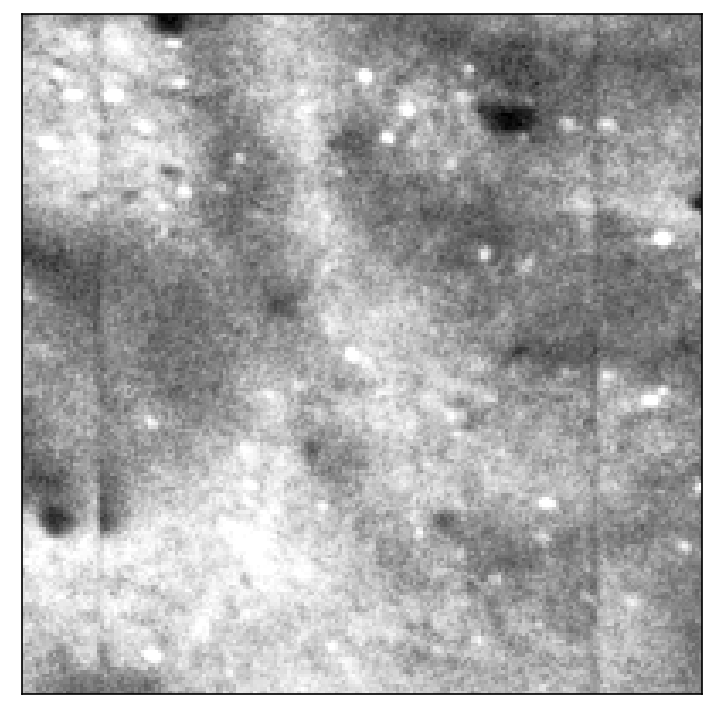

In [103]:
tfu.show_tif(im_small)

In [101]:
mov3d_small = darr.swapaxes(mov_small, 0, 1).compute().astype(n.float32)

In [102]:
nt, nz, ny, nx = mov3d_small.shape

In [107]:
batchsize = 100
vmap = n.zeros((nz, ny, nx))
sdmov = n.zeros((nz, ny, nx))
for i in range(0,nt, batchsize):
    print(i)
    mov = mov3d_small[i:i+batchsize].copy()
    iter_step.run_detection(mov, vmap, sdmov, i, temporal_high_pass_width=batchsize,
                 do_running_sdmov=True, npil_hpf_xy = 35, npil_hpf_z = 1, 
                 unif_filter_xy = 3, unif_filter_z = 3, intensity_thresh=0)

0
Temporal high-pass filtering
Begin Detect
After shmem
After hpf
Computing standard deviation of pixels over time
After sdmov
Why is the scale different between n_proc=1 and n_proc > 1
Neuropil subtraction and convolution
After Norm
Before 3D filter
After 3D filter
Vmap calculation
After vmap
Before unlink
After unlink
Before return
100
Temporal high-pass filtering
Begin Detect
After shmem
After hpf
Computing standard deviation of pixels over time
After sdmov
Why is the scale different between n_proc=1 and n_proc > 1
Neuropil subtraction and convolution
After Norm
Before 3D filter
After 3D filter
Vmap calculation
After vmap
Before unlink
After unlink
Before return
200
Temporal high-pass filtering
Begin Detect
After shmem
After hpf
Computing standard deviation of pixels over time
After sdmov
Why is the scale different between n_proc=1 and n_proc > 1
Neuropil subtraction and convolution
After Norm
Before 3D filter
After 3D filter
Vmap calculation
After vmap
Before unlink
After unlink
Be

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x256a0100550>)

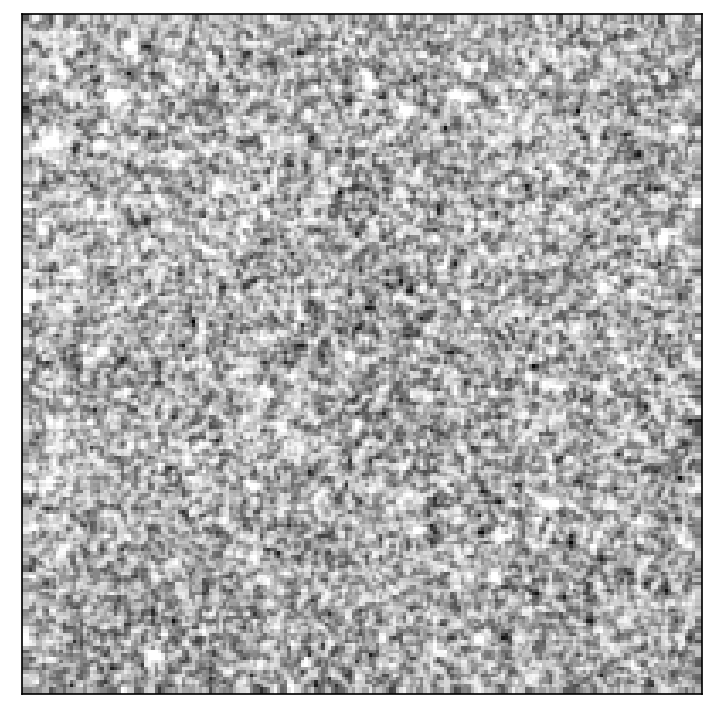

In [109]:
# This is the correlation map
# Looks pretty bad because I only used 300 frames, re-run with more frames by registering more tifs 
# and you'll get something nicer
tfu.show_tif(vmap[3]**0.5)